In [1]:
from Scripts import Trainings
from Scripts import Plotting
from Scripts import Computing_functions
#from Scripts/Caching import Plotting_old
#from Scripts/Caching import Computing_functions_old
import sys
import gc
import numpy as np
import timeit
import itertools
import importlib
import os
import glob
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import xarray as xr
import re
import seaborn as sns
import ast
import math
sns.set_context('paper') 
OcT = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4']
Var_X_BIG_Extra = ['iceDraft', 'bathymetry', 'Slope_iceDraft_x', 'Slope_bathymetry_x',
                   'Slope_iceDraft_y', 'Slope_bathymetry_y', 'Big_T', 'Big_S',
                  'Distances_ground_line', 'Distances_front_line']
Var_X_BIG_Slope = ['iceDraft', 'bathymetry', 'Slope_iceDraft', 'Slope_bathymetry', 'Big_T', 'Big_S',
                  'Distances_ground_line', 'Distances_front_line']
Var_X_BIG_T_S = ['Big_T', 'Big_S']

Var_X_slopexy = ['iceDraft', 'bathymetry', 'Slope_iceDraft_x', 'Slope_bathymetry_x',
                   'Slope_iceDraft_y', 'Slope_bathymetry_y', 'temperatureYZ', 'salinityYZ',
                  'Distances_ground_line', 'Distances_front_line']

OcTPlus = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4', 'CPL_EXP10_rst']
CPLs_test = ['CPL_EXP10_rst', 'CPL_EXP22_rst', 'CPL_EXP23_rst']

ALL_EXP = ['CPL_EXP10_rst','CPL_EXP11_rst', 'CPL_EXP12_rst','CPL_EXP13_rst','CPL_EXP20_rst','CPL_EXP21_rst','CPL_EXP22_rst', 'CPL_EXP23_rst']
Train_oc_exp = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4', 'CPL_EXP10_rst','CPL_EXP13_rst', 'CPL_EXP22_rst', 'CPL_EXP23_rst']

Var_X_non_position_driving = ['thermalDriving', 'halineDriving', 'iceDraft']
Var_X_non_position = ['temperatureYZ', 'salinityYZ', 'iceDraft']
NEW = ['IceOcean1r_ElmerIce', 'IceOcean1ra_ElmerIce']
NEW_under100supr = ['IceOcean1r_ElmerIce_under100supr', 'IceOcean1ra_ElmerIce_under100supr']
NEW_fill100 = ['IceOcean1r_ElmerIce_fill100', 'IceOcean1ra_ElmerIce_fill100']

importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)

2022-09-08 03:57:20.213859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-08 03:57:20.213920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


PWD : /home/bouissob/Code
PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [46]:
#Trainings.Get_model_path_json(Ocean = OcT, Var = Var_X_non_position, return_all = True)


In [51]:
p = Trainings.Get_model_path_json(Ocean = OcT, Var = Var_X_non_position)[0]
uniq = 1646910997
p = Trainings.Get_model_path_json(Ocean = OcT, Var = Var_X_non_position, Uniq_id = uniq)[0]
#p = Trainings.Get_model_path_json(Ocean = OcT, Var = Var_X_non_position, Neur = '8_16')[0]

Config = Trainings.Get_model_attributes(p)
Path = f'{p}/model_{Config["Epoch"]}.h5'

In [52]:
Model = tf.keras.models.load_model(Path)

In [53]:
li = Model.weights

In [54]:
#li

In [55]:
p

'/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_8_8_Ch_0-1646910997_Ex_'

In [75]:
def Extract_keras_layers_from_list(li):
    bias_vect = []
    weight_vect_matrice = []
    for i, elem in enumerate(li):
        if i != 0 and i != 1:
            if i%2 == 0:
                weight_vect_matrice.append(elem)
            else:
                bias_vect.append(elem)
    return weight_vect_matrice, bias_vect

In [87]:
bias1 = li[1]
matrice1 = li[2]
bias2 = li[3]
vect2 = li[4]
bias3 = li[5]
for i, item in enumerate(Config['Var_X']):
    vect1 = li[0][i]
    importance = np.dot(np.dot(vect1 + bias1, matrice1 + bias2), vect2 + bias3)
    print(f'Importance of {item} : {importance}')

Importance of temperatureYZ : [-6.0121665]
Importance of salinityYZ : [-6.1461473]
Importance of iceDraft : [-12.576553]


In [86]:
weights_vectors, bias_vectors = Extract_keras_layers_from_list(li)
for i, item in enumerate(Config['Var_X']):
    vect1 = li[0][i]
    Bias1 = li[1]
    importance = vect1 + Bias1
    for i,j in zip(weights_vectors, bias_vectors):
        importance = np.dot(importance, i + j)
    print(f'Importance of {item} : {importance}')

Importance of temperatureYZ : [-6.0121665]
Importance of salinityYZ : [-6.1461473]
Importance of iceDraft : [-12.576553]


In [80]:
def Compute_Var_importance(li):
    weights_vectors, bias_vectors = Extract_keras_layers_from_list(li)
    Score = []
    for i, item in enumerate(Config['Var_X']):
        vect1 = li[0][i]
        Bias1 = li[1]
        importance = vect1 + Bias1
        for i,j in zip(weights_vectors, bias_vectors):
            importance = np.dot(importance, i + j)

    #   importance = np.dot(np.dot(vect1 + bias1, matrice1 + bias2), vect2 + bias3)
        Score.append(importance)
        print(f'Importance of {item} : {importance}')
    return Score

In [83]:
ps = Trainings.Get_model_path_json(Ocean = OcT, Var = Var_X_non_position, Neur = '8_8', return_all = True)
for p in ps:
    Config = Trainings.Get_model_attributes(p)
    Path = f'{p}/model_{Config["Epoch"]}.h5'
    Model = tf.keras.models.load_model(Path)
    li = Model.weights
    print('Ben')
    Compute_Var_importance(li)

Ben
Importance of temperatureYZ : [-27.977573]
Importance of salinityYZ : [-82.19856]
Importance of iceDraft : [-31.481203]
Ben
Importance of temperatureYZ : [6.0280986]
Importance of salinityYZ : [-96.61713]
Importance of iceDraft : [-5.0541725]
Ben
Importance of temperatureYZ : [-6.0121665]
Importance of salinityYZ : [-6.1461473]
Importance of iceDraft : [-12.576553]


In [85]:
li

[<tf.Variable 'dense_12/kernel:0' shape=(3, 8) dtype=float32, numpy=
 array([[-0.01521313, -1.7622736 ,  1.4565691 ,  0.7154621 ,  0.7979081 ,
          0.54309523, -1.1459472 , -1.1210864 ],
        [-0.37394705,  1.1400106 , -1.2340045 ,  0.03456183, -1.095746  ,
         -0.09861507, -0.18948421, -0.11897589],
        [-0.50899714,  0.16942687, -1.152033  ,  0.21485233,  0.02394121,
          0.21899581,  1.6163313 , -0.8360859 ]], dtype=float32)>,
 <tf.Variable 'dense_12/bias:0' shape=(8,) dtype=float32, numpy=
 array([ 1.4798659 ,  1.406207  , -0.40277258, -0.9612187 ,  0.505024  ,
        -0.10208588,  0.39268154,  2.0762563 ], dtype=float32)>,
 <tf.Variable 'dense_13/kernel:0' shape=(8, 8) dtype=float32, numpy=
 array([[ 0.17406267,  1.2652867 ,  0.3232769 ,  1.5566559 , -1.4777354 ,
         -1.1045353 , -2.1646142 , -1.6157672 ],
        [-1.0572802 ,  0.3116191 , -1.7766889 , -0.00989419,  0.17028664,
         -0.01823604, -0.570299  , -3.7167659 ],
        [-2.2441888 ,  0.2

In [ ]:
Trainings.Get_model_path_json(Ocean = OcT, Var = Var_X_non_position, return_all = True)

['/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_1_Ch_0-1646907496_Ex_',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_4_Ch_0-1646908085_Ex_',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_8_Ch_0-1646908696_Ex_',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_16_Ch_0-1646909262_Ex_',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_32_Ch_0-1646909835_Ex_',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_64_Ch_0-1646910386_Ex_',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_8_8_Ch_0-1646910997_Ex_',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_8_16_Ch_0-1646911636_Ex_',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_8_N_8_32_Ch_0-1646912274_Ex_',
 '/home/bouissob/Code/Auto_model/CO

In [2]:
File_path = '/bettik/bouissob/ISOMIP+/'
Bet_path = '/bettik/bouissob/'
Path = '/bettik/bouissob/Method_Data/COM_NEMO-CNRS/Method_1/Ocean1.csv'

In [3]:
Mod = {'Ocean' : OcT, 'Var' : Var_X_BIG_Extra, 'Extra_n' : 'Batch_Size_Benchmark'}


A = Plotting.Variable_benchmark_plotting(NN_attributes = Mod, Ocean_target = 'Ocean1')

Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656491807_Ex_Batch_Size_Benchmark/model_64.h5


2022-09-07 17:42:15.623436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-07 17:42:15.623505: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-07 17:42:15.623544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke60): /proc/driver/nvidia/version does not exist
2022-09-07 17:42:15.624270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done computing for Ocean1 in : 3 s


In [4]:
B = A[0]

In [5]:
df = B.to_dataframe().dropna()

In [17]:
corr = df.corr()

In [24]:
corr.style.background_gradient(cmap='coolwarm')


In [27]:
df['error'] = df.Mod_melt - df.meltRate

In [30]:
df.head()

meltRate  thermalDriving  halineDriving   iceDraft  \
date y      x                                                                  
0    1000.0 515000.0  1.445518e-09        0.009086       0.127754  82.815510   
            637000.0  2.533100e-09        0.013837       0.194261  91.276440   
     3000.0 515000.0  1.421181e-09        0.008926       0.125516  81.651650   
            615000.0  2.025993e-09        0.012627       0.177358  89.908270   
            617000.0  1.932426e-09        0.012012       0.168752  90.281364   

                      bathymetry  Distances_ground_line  Distances  \
date y      x                                                        
0    1000.0 515000.0   124.00000                 2000.0     2000.0   
            637000.0   579.32086               124000.0   124000.0   
     3000.0 515000.0   124.00000                 2000.0     2000.0   
            615000.0   393.43146               102000.0   102000.0   
            617000.0   407.81378               104000.0   104000.0   

                      Distances_front_line  Slope_iceDraft  Slope_iceDraft_x  \
date y      x                                                                  
0    1000.0 515000.0                2000.0        0.000000               0.0   
            637000.0                2000.0        7.109749               0.0   
     3000.0 515000.0                2000.0        0.000000               0.0   
            615000.0                2000.0        8.020058               0.0   
            617000.0                2000.0        8.546814               0.0   

                      ...       S_32       S_33       S_34       S_35  \
date y      x         ...                                               
0    1000.0 515000.0  ...  33.898857  33.898857  33.898857  33.898857   
            637000.0  ...  33.898857  33.898857  33.898857  33.898857   
     3000.0 515000.0  ...  33.898888  33.898888  33.898888  33.898888   
            615000.0  ...  33.898888  33.898888  33.898888  33.898888   
            617000.0  ...  33.898888  33.898888  33.898888  33.898888   

                           S_36       S_37       S_38       S_39  \
date y      x                                                      
0    1000.0 515000.0  33.898857  33.898857  33.898857  33.898857   
            637000.0  33.898857  33.898857  33.898857  33.898857   
     3000.0 515000.0  33.898888  33.898888  33.898888  33.898888   
            615000.0  33.898888  33.898888  33.898888  33.898888   
            617000.0  33.898888  33.898888  33.898888  33.898888   

                          Mod_melt         error  
date y      x                                     
0    1000.0 515000.0 -1.613039e-09 -3.058556e-09  
            637000.0  3.122331e-09  5.892308e-10  
     3000.0 515000.0 -1.448512e-09 -2.869693e-09  
            615000.0  2.150852e-09  1.248585e-10  
            617000.0  1.860521e-09 -7.190557e-11  

[5 rows x 96 columns]

In [31]:
New_corr = df.corr()[['error']]

In [32]:
New_corr.style.background_gradient(cmap='coolwarm')


,error
meltRate,-0.092622
thermalDriving,-0.035496
halineDriving,-0.034465
iceDraft,-0.017688
bathymetry,-0.003284
Distances_ground_line,-0.006218
Distances,-0.006218
Distances_front_line,-0.017952
Slope_iceDraft,-0.000919
Slope_iceDraft_x,-0.008085


In [7]:
df.head()

meltRate  thermalDriving  halineDriving   iceDraft  \
date y      x                                                                  
0    1000.0 515000.0  1.445518e-09        0.009086       0.127754  82.815510   
            637000.0  2.533100e-09        0.013837       0.194261  91.276440   
     3000.0 515000.0  1.421181e-09        0.008926       0.125516  81.651650   
            615000.0  2.025993e-09        0.012627       0.177358  89.908270   
            617000.0  1.932426e-09        0.012012       0.168752  90.281364   

                      bathymetry  Distances_ground_line  Distances  \
date y      x                                                        
0    1000.0 515000.0   124.00000                 2000.0     2000.0   
            637000.0   579.32086               124000.0   124000.0   
     3000.0 515000.0   124.00000                 2000.0     2000.0   
            615000.0   393.43146               102000.0   102000.0   
            617000.0   407.81378               104000.0   104000.0   

                      Distances_front_line  Slope_iceDraft  Slope_iceDraft_x  \
date y      x                                                                  
0    1000.0 515000.0                2000.0        0.000000               0.0   
            637000.0                2000.0        7.109749               0.0   
     3000.0 515000.0                2000.0        0.000000               0.0   
            615000.0                2000.0        8.020058               0.0   
            617000.0                2000.0        8.546814               0.0   

                      ...       S_31       S_32       S_33       S_34  \
date y      x         ...                                               
0    1000.0 515000.0  ...  33.898857  33.898857  33.898857  33.898857   
            637000.0  ...  33.898857  33.898857  33.898857  33.898857   
     3000.0 515000.0  ...  33.898888  33.898888  33.898888  33.898888   
            615000.0  ...  33.898888  33.898888  33.898888  33.898888   
            617000.0  ...  33.898888  33.898888  33.898888  33.898888   

                           S_35       S_36       S_37       S_38       S_39  \
date y      x                                                                 
0    1000.0 515000.0  33.898857  33.898857  33.898857  33.898857  33.898857   
            637000.0  33.898857  33.898857  33.898857  33.898857  33.898857   
     3000.0 515000.0  33.898888  33.898888  33.898888  33.898888  33.898888   
            615000.0  33.898888  33.898888  33.898888  33.898888  33.898888   
            617000.0  33.898888  33.898888  33.898888  33.898888  33.898888   

                          Mod_melt  
date y      x                       
0    1000.0 515000.0 -1.613039e-09  
            637000.0  3.122331e-09  
     3000.0 515000.0 -1.448512e-09  
            615000.0  2.150852e-09  
            617000.0  1.860521e-09  

[5 rows x 95 columns]

In [6]:
def Variable_function(df):
    
    
    pass

2022-09-01 18:03:25.874085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-01 18:03:25.874142: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-01 18:03:25.874188: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke60): /proc/driver/nvidia/version does not exist
2022-09-01 18:03:25.874909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656491807_Ex_Batch_Size_Benchmark/model_64.h5
Done computing for Ocean1 in : 4 s


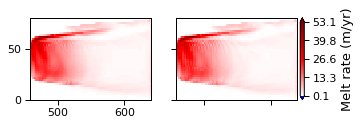

In [7]:
Mod = [{'Ocean' : OcT, 'Var' : Var_X_BIG_Extra, 'Extra_n' : 'Batch_Size_Benchmark'}
      ]
A = Plotting.plot_N_side_exp(Trainings.model_NN, Mod, T = [0], Ocean_target = 'Ocean1', save = False, 
                            Title = [], One_profile = True, message = False, Only_reference = False,
                            sharing=False, Display_label = False, Dimensions = (6, 1.5))

In [9]:
A = A[0]

In [12]:
B = A.to_dataframe()

In [4]:
NN_attributes = {'Ocean' : OcT, 'Extra_n' : 'Downsample_benchmark'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Downsample_Multiplier', 
            Ocean_target = OcT, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1661863721_Ex_Downsample_benchmark, ( 1 / 15)


2022-08-30 17:49:52.138333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-30 17:49:52.138397: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-30 17:49:52.138420: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke60): /proc/driver/nvidia/version does not exist
2022-08-30 17:49:52.138860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1661865564_Ex_Downsample_benchmark, ( 2 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1661866117_Ex_Downsample_benchmark, ( 3 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1661866431_Ex_Downsample_benchmark, ( 4 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1661866659_Ex_Downsample_benchmark, ( 5 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1661866852_Ex_Downsample_benchmark, ( 6 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1661868706_Ex_Downsample_benchmark, ( 7 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N

In [6]:
NN_attributes = {'Ocean' : OcT, 'Extra_n' : 'Downsample_benchmark_big'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Downsample_Multiplier', 
            Ocean_target = OcT, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1661877389_Ex_Downsample_benchmark_big, ( 1 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1661880440_Ex_Downsample_benchmark_big, ( 2 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1661881316_Ex_Downsample_benchmark_big, ( 3 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1661881770_Ex_Downsample_benchmark_big, ( 4 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1661882059_Ex_Downsample_benchmark_big, ( 5 / 15)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1661882289_Ex_Downsample_benchmark_big, ( 6 / 15)
Model : /home/bo

In [2]:
%run ./Job_script/Train_job.py

Init training 0
Projected training regiment :
 ['32_32_96_96']
Starting training for neurone : 32_32_96_96, 0/1 (Previous step : 0.000 s)
                   Var_to_load:  808.0 B
                     Coord_var:   96.0 B
                          self:   64.0 B
                         Ocean:   55.0 B
                           dfT:   32.0 B
Loading Ocean1 dataset
                           dfT: 489.9 MiB
                   Var_to_load:  808.0 B
                     Coord_var:   96.0 B
                          self:   64.0 B
                         Ocean:   55.0 B
                          name:   52.0 B
                          size:   28.0 B
Loading Ocean2 dataset
                           dfT:  1.0 GiB
                   Var_to_load:  808.0 B
                     Coord_var:   96.0 B
                          self:   64.0 B
                         Ocean:   55.0 B
                          name:   53.0 B
                          size:   28.0 B
Loading Ocean3 dataset
             

2022-08-25 17:47:09.100771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-25 17:47:09.100830: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-25 17:47:09.100870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke62): /proc/driver/nvidia/version does not exist
2022-08-25 17:47:09.101468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[<keras.layers.core.dense.Dense object at 0x7fbdc6d94f10>, <keras.layers.core.dense.Dense object at 0x7fbdc6d9b110>, <keras.layers.core.dense.Dense object at 0x7fbdc6ebb3d0>, <keras.layers.core.dense.Dense object at 0x7fbdc6805fd0>, <keras.layers.core.dense.Dense object at 0x7fbdc9891a10>]
Epoch 1/32
1488/7308 [=====>........................] - ETA: 24s - loss: 0.0914 - mae: 0.1062 - mse: 0.0914

KeyboardInterrupt: 

/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1660050104_Ex_Batch_Size_Benchmark2
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1660077465_Ex_Batch_Size_Benchmark2
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1660094141_Ex_Batch_Size_Benchmark2
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1660096864_Ex_Batch_Size_Benchmark2
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1660098820_Ex_Batch_Size_Benchmark2
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1660126542_Ex_Batch_Size_Benchmark2
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1660143071_Ex_Batch_Size_Benchmark2
/home/

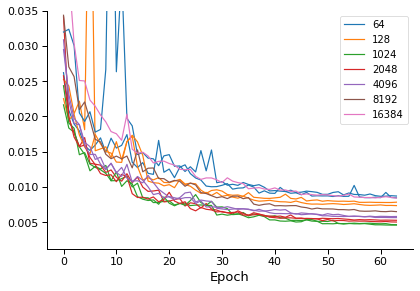

In [18]:
Mod = [{'Ocean' : OcT, 'Extra_n' :  'Batch_Size_Benchmark2', 'return_all' : True}
      ]#{'Ocean' : OcT, 'Uniq_id' : 1653041657}]
Plotting.Plot_Loss_against_loss(Mods = Mod, Desired_comparaison=['val_mse'], #cmap = 'BrBG',
                                save = False, Desired_length=64, ylim = 0.035, Generic_label = 'batch_size')
#                label = ['No lr changes', 'Lr /5 every 8', 'Lr /2 every 10', 'lr plateau'])
#label = ['No lr changes', 'Lr /5 every 8', 'Lr /2 every 10', 'lr plateau']

In [14]:
8192*2

16384

Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659544681_Ex_Time_cutting_10percent/model_64.h5
Done computing for Ocean1 in : 1 s
['Ocean1'] : [12.981396376814809] Gt/yr 

Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659544681_Ex_Time_cutting_10percent/model_64.h5
Done computing for Ocean2 in : 1 s
['Ocean2'] : [0.9185132050469342] Gt/yr 

Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659544681_Ex_Time_cutting_10percent/model_64.h5
Done computing for Ocean3 in : 7 s
['Ocean3'] : [3.342247188049082] Gt/yr 

Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659544681_Ex_Time_cutting_10percent/model_64.h5
Done computing for Ocean4 in : 7 s
['Ocean4'] : [0.1289195896296327] Gt/yr 



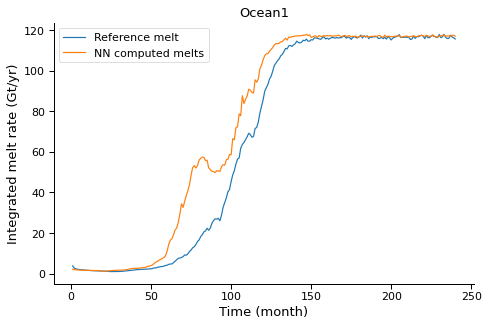

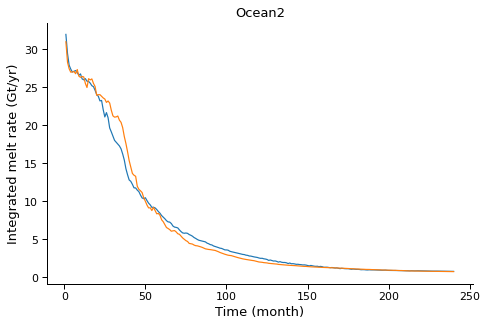

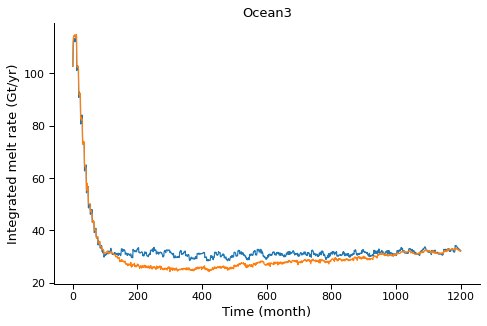

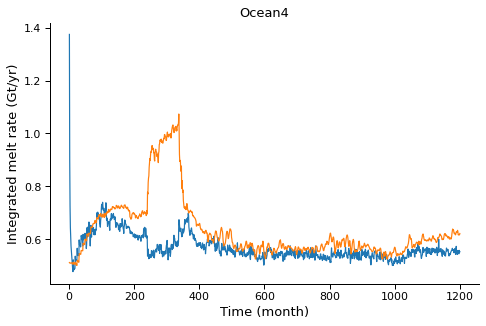

In [4]:
Mod = [{'Ocean' : OcT, 'Extra_n' : 'Time_cutting_10percent'}]
for i, oc in enumerate(OcT):
    if i ==0:
        Display_label = True
    else:
        Display_label = False
    RMSE = Plotting.Plot_Melt_time_function(save = False, Ocean_target = oc, Display_label=Display_label,
            Type_target = 'COM_NEMO-CNRS', NN_attributes = Mod, Save_name = '', Display_title = True, Title = oc)

In [5]:
Trainings.Get_model_path_json(Ocean = OcT, Var = Var_X_BIG_T_S, return_all = True)

['/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659021076_Ex_Spatial_Cutting_benchmark_simple_T_S',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659021722_Ex_Spatial_Cutting_benchmark_simple_T_S']

In [55]:
importlib.reload(Plotting)


<module 'Scripts.Plotting' from '/home/bouissob/Code/Scripts/Plotting.py'>

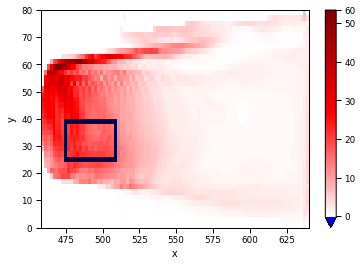

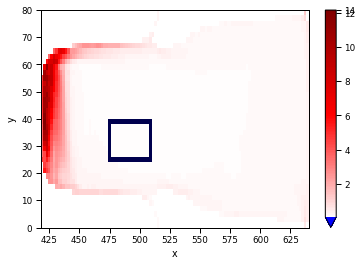

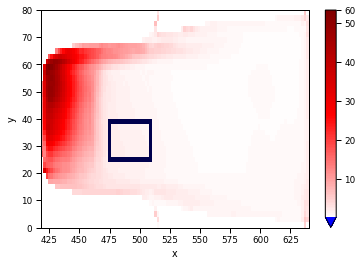

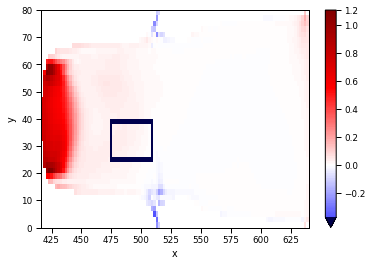

In [56]:
Desired_box = np.array([475, 510, 25, 40])*1000
for oc in OcT:
    A = Plotting.Plot_spatial_selection(oc, box = 'Partial', Desired_box = Desired_box, save = True)

In [42]:
B = A.copy()
xmin, xmax = Desired_box[0:2]
ymin, ymax = Desired_box[2:4]
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [45]:
B = A.copy()
# Upper boundary x 

B = xr.where( (B.x >= find_nearest(B.x, xmin)) & (B.x <= find_nearest(B.x, xmax)) & (B.y == find_nearest(B.y, ymax)), np.nan, B)

# Lower boundary x 
B = xr.where( (B.x >= find_nearest(B.x, xmin)) & (B.x <= find_nearest(B.x, xmax)) & (B.y == find_nearest(B.y, ymin)), np.nan, B)

# Upper boundary y 
B = xr.where( (B.y >= find_nearest(B.y, ymin)) & (B.y <= find_nearest(B.y, ymax)) & (B.x == find_nearest(B.x, xmax)), np.nan, B)

# Lower boundary y 
B = xr.where( (B.y >= find_nearest(B.y, ymin)) & (B.y <= find_nearest(B.y, ymax)) & (B.x == find_nearest(B.x, xmin)), np.nan, B)

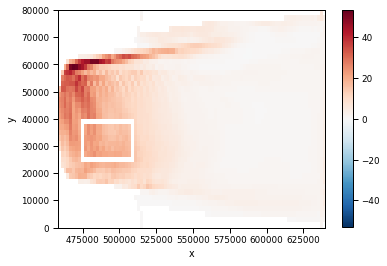

In [46]:
B.plot()

PWD : /home/bouissob/Code


2022-08-03 03:17:15.212795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-03 03:17:15.212847: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-03 03:17:15.212886: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke60): /proc/driver/nvidia/version does not exist
2022-08-03 03:17:15.213441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1658947583_Ex_Spatial_Cutting_benchmark/model_64.h5
Done computing for Ocean1 in : 2 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1658947039_Ex_Spatial_Cutting_benchmark/model_64.h5
Done computing for Ocean1 in : 2 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1658946504_Ex_Spatial_Cutting_benchmark/model_64.h5
Done computing for Ocean1 in : 2 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1658945939_Ex_Spatial_Cutting_benchmark/model_64.h5
Done computing for Ocean1 in : 2 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1658947583_Ex_Spatial_Cutting_benchmark/model_64.h5
Done computing for Ocean2 in : 2 s
Model used

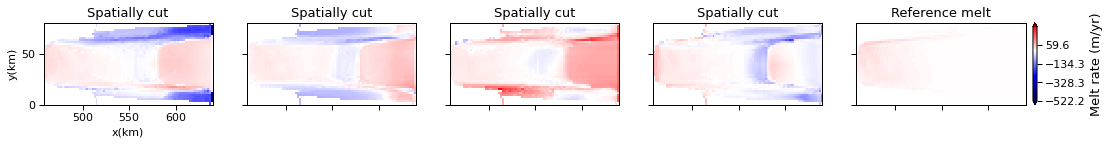

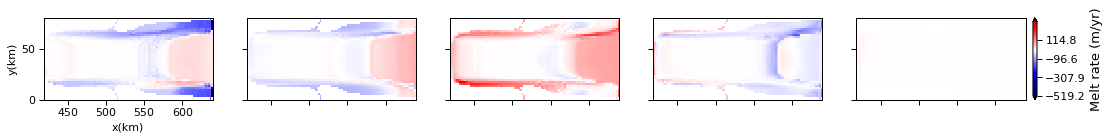

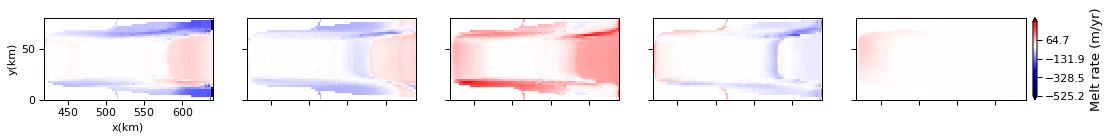

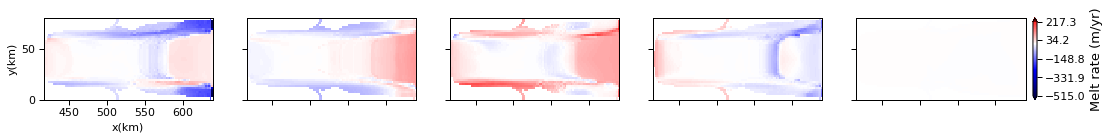

In [3]:
Mod = [{'Ocean' : OcT, 'Uniq_id' : 1658947583}, {'Ocean' : OcT, 'Uniq_id' : 1658947039},
       {'Ocean' : OcT, 'Uniq_id' : 1658946504}, {'Ocean' : OcT, 'Uniq_id' : 1658945939}
      ]
Title = ['Spatially cut', 'Spatially cut', 'Spatially cut','Spatially cut', 'Reference melt']
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)
Display_label = True
for i, oc in enumerate(OcT):
    if i != 0:
        Title = []
    _ = Plotting.plot_N_side_exp(Trainings.model_NN, Mod,T = [0], Ocean_target = oc, save = True, 
                            Title = Title, One_profile = True, Dimensions = (5.5, 1.5),
                                 sharing=False, Display_label = True)


In [ ]:
Mod = [{'Ocean' : OcT, 'Uniq_id' : 1659021076}, {'Ocean' : OcT, 'Uniq_id' : 1659021722},
       {'Ocean' : OcT, 'Uniq_id' : 1659024314}
      ]
Title = ['Spatial cutting', 'Spatial cutting','Spatial cutting and iceD', 'Reference melt']
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)
Display_label = True
for i, oc in enumerate(OcT):
    if i != 0:
        Title = []
    _ = Plotting.plot_N_side_exp(Trainings.model_NN, Mod,T = [0], Ocean_target = oc, save = False, 
                            Title = Title, One_profile = True, Dimensions = (5.5, 1.5),
                                 sharing=False, Display_label = True)

PWD : /home/bouissob/Code
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659021076_Ex_Spatial_Cutting_benchmark_simple_T_S/model_64.h5
Done computing for Ocean1 in : 2 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659021722_Ex_Spatial_Cutting_benchmark_simple_T_S/model_64.h5
Done computing for Ocean1 in : 2 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659024314_Ex_Spatial_Cutting_benchmark_simple_T_S/model_64.h5
Done computing for Ocean1 in : 2 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659021076_Ex_Spatial_Cutting_benchmark_simple_T_S/model_64.h5
Done computing for Ocean2 in : 2 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_32_32_96_96_Ch_0-1659021722_Ex_Spatial_Cutti

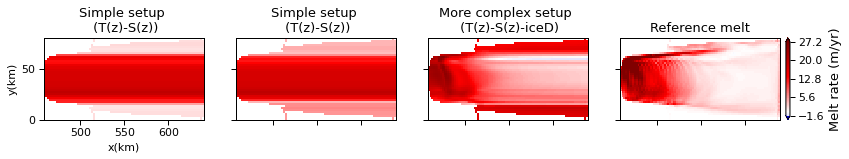

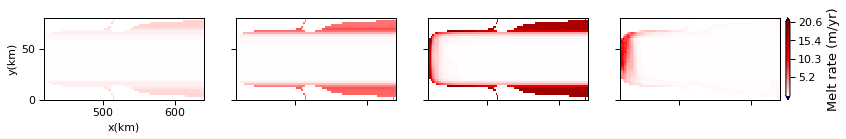

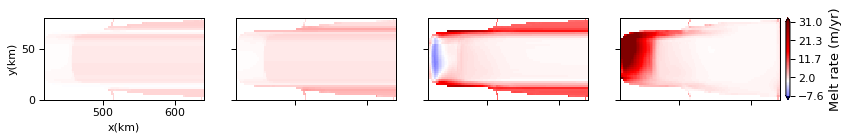

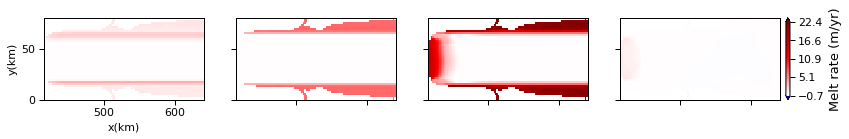

In [6]:
Mod = [{'Ocean' : OcT, 'Uniq_id' : 1659021076}, {'Ocean' : OcT, 'Uniq_id' : 1659021722},
       {'Ocean' : OcT, 'Uniq_id' : 1659024314}
      ]
Title = ['Simple setup \n (T(z)-S(z))', 'Simple setup \n (T(z)-S(z))','More complex setup \n (T(z)-S(z)-iceD)', 
         'Reference melt']
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)
Display_label = True
for i, oc in enumerate(OcT):
    if i != 0:
        Title = []
    _ = Plotting.plot_N_side_exp(Trainings.model_NN, Mod,T = [0], Ocean_target = oc, save = True, 
                            Title = Title, One_profile = True, Dimensions = (5.5, 1.5),
                                 sharing=False, Display_label = True)

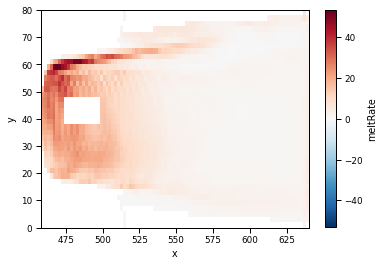

In [69]:
#B.sel(x >= xmin) = np.nan
def Convert_coordinate(min_val, Coord:int, Resol = 2):
    return int((Coord - min_val)/Resol)
bxmin = float(B.x.min())
bymin = float(B.y.min())
B[dict(x=slice(Convert_coordinate(bxmin, xmin), Convert_coordinate(bxmin, xmax)), 
       y=slice(Convert_coordinate(bymin, ymin), Convert_coordinate(bymin, ymax)))] = np.nan
B.plot()

In [66]:
(bxmin - xmin ) / 2

-8.0

PWD : /home/bouissob/Code
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384123_Ex_Drivingvsinterp/model_8.h5
Done computing for Ocean1 in : 0 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384062_Ex_Drivingvsinterp/model_8.h5
Done computing for Ocean1 in : 0 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384123_Ex_Drivingvsinterp/model_8.h5
Done computing for Ocean2 in : 0 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384062_Ex_Drivingvsinterp/model_8.h5
Done computing for Ocean2 in : 0 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384123_Ex_Drivingvsinterp/model_8.h5
Done computing for Ocean3 in : 2 s
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384062_Ex_Drivingvsinterp/model_8.h5
Done computing for Ocean3 in : 2 s
Mo

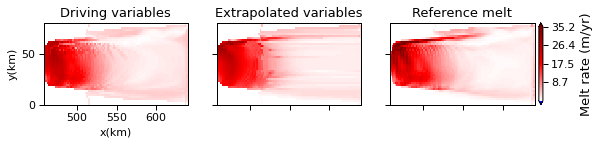

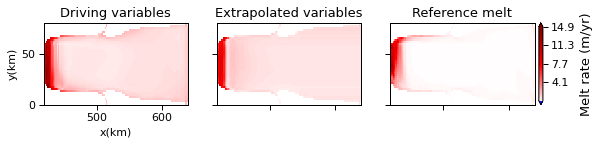

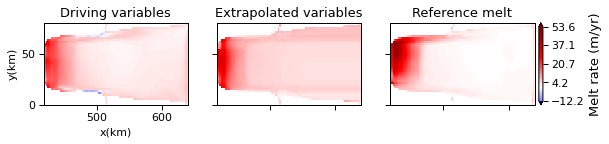

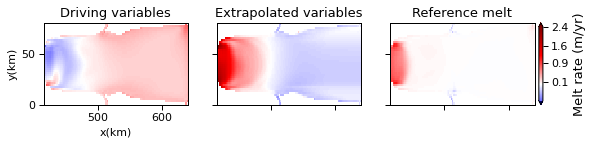

In [14]:
Mod = [{'Ocean' : 'Ocean1', 'Var' : Var_X_non_position_driving, 'Epoch' : 8, 'Extra_n' : 'Drivingvsinterp'}, 
       {'Ocean' : 'Ocean1', 'Var' : Var_X_non_position, 'Epoch' : 8, 'Extra_n' : 'Drivingvsinterp'} 
      ]
Title = ['Driving variables', 'Extrapolated variables', 'Reference melt']
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)
Display_label = True
for oc in OcT:
    A = Plotting.plot_N_side_exp(Trainings.model_NN, Mod,T = [0], Ocean_target = oc, save = False, 
                            Title = Title, One_profile = True, Dimensions = (5.5, 1.5),
                                 sharing=False, Display_label = True)
    Melt_profile = A[0].meltRate
    Melt_profile.to_netcdf(os.getcwd() + f'/Cached_data/Data_for_spatial_cutting/{oc}.nc')

In [2]:
importlib.reload(Trainings)

PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [48]:
OcT = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4']
Var_X_BIG_Slopexy = ['iceDraft', 'bathymetry', 'Slope_iceDraft_x', 'Slope_bathymetry_x',
                   'Slope_iceDraft_y', 'Slope_bathymetry_y', 'Big_T', 'Big_S',
                  'Distances_ground_line', 'Distances_front_line']
Training = Trainings.Sequencial_training(Trainings.model_NN)
Best_Neur = ['32_64_32']
for i in range(1):
    print(f'Init training {i}')
    Training.training(training_extent = 0, verbose = 0, batch_size = 1024, Exact = 1, message = 1,
            Standard_train = Best_Neur, Dataset_train = ['Ocean1'], Epoch = 1, 
            Var_X = Var_X_BIG_Slopexy, Verify = 0, Extra_n = '',
            Similar_training = True, Norm_Choix = 0, Method_data = 4,
            Fraction_save = 50, Scaling_type = 'Plateau', Fraction = 0.1,
            Scaling_lr = True, LR_Patience = 10, LR_min = 0.0000006, LR_Factor = 2, min_delta = 0.003)

Init training 0
Projected training regiment :
 ['32_64_32']
Starting training for neurone : 32_64_32, 0/1 (Previous step : 0.000 s)
Loading Ocean1 dataset
Separate X Y datasets
55799 13993
55799 13993
Del li
55799 13993
55799 13993
Normalisation
55799 13993
55799 13993
After norm 1st fct
55799 13993
55799 13993
Norm final step
55799 13993
55799 13993
After norm
55799 13993
55799 13993


2022-07-25 21:24:04.748616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-25 21:24:04.748712: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-25 21:24:04.748750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke60): /proc/driver/nvidia/version does not exist
2022-07-25 21:24:04.749592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[<keras.layers.core.dense.Dense object at 0x7fe4b4cc7fd0>, <keras.layers.core.dense.Dense object at 0x7fe4b4bee9d0>, <keras.layers.core.dense.Dense object at 0x7fe49709a050>, <keras.layers.core.dense.Dense object at 0x7fe4b4cc7ed0>]
Start Training
55799 13993
55799 13993
Training done after 1 s


In [100]:
importlib.reload(Trainings)

PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [4]:
NN = Trainings.model_NN(**kwargs)

NameError: name 'kwargs' is not defined

In [101]:
kwargs = dict(verbose = 0, batch_size = 1024, Neur_seq = '32_64_32', Dataset_train = ['Ocean1'],  Epoch = 1, 
            Var_X = Var_X_BIG_Slope, Extra_n = '',
            Norm_Choix = 0, Method_data = 4,
            Fraction_save = 50, Scaling_type = 'Plateau',
            Scaling_lr = True, LR_Patience = 10, LR_min = 0.0000006, LR_Factor = 2, min_delta = 0.003)
NN = Trainings.model_NN(**kwargs)

In [102]:
li = NN.Fetch_dataset()

                   Var_to_load:  792.0 B
                     Coord_var:   96.0 B
                          self:   64.0 B
                         Ocean:   55.0 B
                           dfT:   32.0 B
Loading Ocean1 dataset


In [147]:
Desired_box

array([475000, 510000,  25000,  40000])

In [105]:

xmin, xmax = Desired_box[0:2]
ymin, ymax = Desired_box[2:4]

In [112]:
li.x >= xmin && li.x <= xmax

SyntaxError: invalid syntax (3064355132.py, line 1)

In [114]:
li.loc[(li.x >= xmin) & (li.x <= xmax) & (li.y >= ymin) & (li.y <= ymax)]

,y,x,meltRate,iceDraft,bathymetry,date,Distances_ground_line,Distances_front_line,Slope_iceDraft,Slope_bathymetry,...,S_30,S_31,S_32,S_33,S_34,S_35,S_36,S_37,S_38,S_39
734,25000.0,475000.0,3.004173e-08,495.72925,606.72300,0,8944.271910,43863.424399,30.560349,13.204274,...,34.378990,34.378990,34.399460,34.41471,34.414710,34.414710,34.414710,34.414710,34.414710,34.414710
735,25000.0,477000.0,2.936189e-08,483.59330,605.85010,0,10000.000000,42047.592083,29.563549,13.190806,...,34.378990,34.378990,34.399460,34.41471,34.414710,34.414710,34.414710,34.414710,34.414710,34.414710
736,25000.0,479000.0,2.891195e-08,472.05566,605.05150,0,10000.000000,40249.223595,28.920717,13.182377,...,34.378990,34.378990,34.399460,34.41471,34.414710,34.414710,34.414710,34.414710,34.414710,34.414710
737,25000.0,481000.0,2.708006e-08,461.08185,604.24600,0,10000.000000,38470.768123,28.159285,13.926314,...,34.378990,34.378990,34.399460,34.41471,34.414710,34.414710,34.414710,34.414710,34.414710,34.414710
738,25000.0,483000.0,2.679992e-08,450.71698,600.00000,0,10000.000000,36715.119501,28.183186,13.654769,...,34.378990,34.378990,34.399460,34.41471,34.414710,34.414710,34.414710,34.414710,34.414710,34.414710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696395,39000.0,501000.0,9.307710e-07,400.00000,604.58655,239,24738.633754,34928.498393,17.655151,0.420172,...,34.534653,34.534653,34.554504,34.57147,34.577152,34.577152,34.577152,34.577152,34.577152,34.577152
696396,39000.0,503000.0,8.592824e-07,390.74908,604.41534,239,25298.221281,34176.014981,18.090260,0.260484,...,34.534653,34.534653,34.554504,34.57147,34.577152,34.577152,34.577152,34.577152,34.577152,34.577152
696397,39000.0,505000.0,8.598982e-07,381.92130,604.32620,239,26000.000000,33526.109228,17.683940,0.092291,...,34.534653,34.534653,34.554504,34.57147,34.577152,34.577152,34.577152,34.577152,34.577152,34.577152
696398,39000.0,507000.0,7.661475e-07,373.07422,604.32336,239,26000.000000,32984.845005,17.720842,0.085778,...,34.534653,34.534653,34.554504,34.57147,34.577152,34.577152,34.577152,34.577152,34.577152,34.577152


In [5]:
X = li[NN.Var_X]

In [6]:
del li

In [16]:
gc.collect()

960

In [ ]:
NN.Separate_X_Y(li)

Separate X Y datasets


In [47]:
NN.Separate_X_Y(li)
NN.Normalize_Train_valid_ds()

Separate X Y datasets
Normalisation
55834 13958
55834 13958
After norm 1st fct
55834 13958
55834 13958
Norm final step
55834 13958
55834 13958


In [46]:
NN.Normalise()
print(len(NN.X_train), len(NN.X_valid))
print(len(NN.Y_train), len(NN.Y_valid))

55834 13958
55834 13958


In [26]:
#self.X_train, self.X_valid
A, B = (np.array((NN.X_train - NN.meanX)/NN.stdX), 
        np.array((NN.X_valid - NN.meanX)/NN.stdX))
#self.Y_train, self.Y_valid
C, D = (np.array((NN.Y_train - NN.meanY)/NN.stdY), 
        np.array((NN.Y_valid - NN.meanY)/NN.stdY))

In [38]:
NN.X_train.mean()

iceDraft                   246.571586
bathymetry                 557.680583
Slope_iceDraft              18.773265
Slope_bathymetry            47.222089
Distances_ground_line    55657.497490
                             ...     
S_35                        34.338624
S_36                        34.338624
S_37                        34.338624
S_38                        34.338624
S_39                        34.338624
Length: 86, dtype: float64

In [40]:
(NN.X_train - NN.meanX.mean())

,iceDraft,bathymetry,Slope_iceDraft,Slope_bathymetry,Distances_ground_line,Distances_front_line,T_0,T_1,T_2,T_3,...,S_30,S_31,S_32,S_33,S_34,S_35,S_36,S_37,S_38,S_39
67890,323.167064,54.515617,5.358750,-32.631595,-50000.643241,32166.171205,-0.229140,-0.229140,-0.229140,-0.229140,...,0.436113,0.436113,0.486577,0.508345,0.508345,0.508345,0.508345,0.508345,0.508345,0.508345
9245,-15.529426,71.363117,-9.843256,-41.417879,-16262.066283,3024.850182,-0.363657,-0.363657,-0.363657,-0.363657,...,0.448171,0.448171,0.475605,0.496535,0.500735,0.500735,0.500735,0.500735,0.500735,0.500735
20731,27.247514,-142.947433,29.179318,164.337241,-51657.497490,-10204.820203,-0.767909,-0.767909,-0.767909,-0.767909,...,0.098105,0.098105,0.098105,0.098105,0.098105,0.098105,0.098105,0.098105,0.098105,0.098105
50779,-64.774686,162.319417,64.458355,-47.222089,71919.929980,-18975.149818,-0.814288,-0.814288,-0.814288,-0.814288,...,0.269605,0.269605,0.296472,0.318319,0.324548,0.324548,0.324548,0.324548,0.324548,0.324548
14658,-42.200356,161.022787,-16.474409,-43.355973,20237.166354,13024.850182,-0.789128,-0.789128,-0.789128,-0.789128,...,0.274091,0.274091,0.294610,0.310449,0.314315,0.314315,0.314315,0.314315,0.314315,0.314315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36446,-62.297826,119.350057,-11.362202,73.299041,27529.039882,-4975.149818,-0.565800,-0.565800,-0.565800,-0.565800,...,0.348718,0.348718,0.348718,0.348718,0.348718,0.348718,0.348718,0.348718,0.348718,0.348718
47049,243.862414,52.209977,0.796462,-45.649278,-33657.497490,24367.986377,-0.778766,-0.778766,-0.778766,-0.778766,...,0.271925,0.271925,0.290015,0.303579,0.306555,0.306555,0.306555,0.306555,0.306555,0.306555
15002,-61.532686,-239.765083,2.483693,172.858341,-16363.732082,-10975.149818,-0.738092,-0.738092,-0.738092,-0.738092,...,0.029622,0.029622,0.029622,0.029622,0.029622,0.029622,0.029622,0.029622,0.029622,0.029622
59668,-137.253636,-137.680583,12.051280,-15.960813,50342.502510,-16975.149818,-0.626215,-0.626215,-0.627646,-0.630510,...,-0.218985,-0.218985,-0.218985,-0.218985,-0.218985,-0.218985,-0.218985,-0.218985,-0.218985,-0.218985


In [27]:
print(len(A), len(B))
print(len(C), len(D))


55835 13958
55834 13958


In [22]:
print(len(NN.X_train), len(NN.X_valid))
print(len(NN.Y_train), len(NN.Y_valid))

55834 13958
55834 13958


In [25]:
NN.meanX

,iceDraft,bathymetry,Slope_iceDraft,Slope_bathymetry,Distances_ground_line,Distances_front_line,T_0,T_1,T_2,T_3,...,S_30,S_31,S_32,S_33,S_34,S_35,S_36,S_37,S_38,S_39
0,246.571586,557.680583,18.773265,47.222089,55657.49749,20975.149818,-1.276172,-1.276172,-1.276172,-1.276172,...,34.110545,34.110545,34.110545,34.110545,34.110545,34.110545,34.110545,34.110545,34.110545,34.110545


In [23]:
print(len(NN.meanX), len(NN.stdX))
print(len(NN.meanY), len(NN.stdY))

1 1
1 1


In [16]:
File_path = '/bettik/bouissob/ISOMIP+/'
Bet_path = '/bettik/bouissob/'
df = pd.DataFrame()
for oc in OcT[:1]:
    print(oc)
    file = f'/bettik/bouissob/Method_Data/COM_NEMO-CNRS/Method_4/{oc}_lite.csv'
    df = pd.concat([df, pd.read_csv(file)], ignore_index=True)

Ocean1


In [17]:
df.head()

,y,x,meltRate,thermalDriving,halineDriving,iceDraft,bathymetry,date,Distances_ground_line,Distances,...,S_30,S_31,S_32,S_33,S_34,S_35,S_36,S_37,S_38,S_39
0,1000.0,515000.0,1.445518e-09,0.009086,0.127754,82.815510,124.00000,0,2000.0,2000.0,...,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857
1,1000.0,637000.0,2.533100e-09,0.013837,0.194261,91.276440,579.32086,0,124000.0,124000.0,...,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857
2,3000.0,515000.0,1.421181e-09,0.008926,0.125516,81.651650,124.00000,0,2000.0,2000.0,...,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888
3,3000.0,615000.0,2.025993e-09,0.012627,0.177358,89.908270,393.43146,0,102000.0,102000.0,...,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888
4,3000.0,617000.0,1.932426e-09,0.012012,0.168752,90.281364,407.81378,0,104000.0,104000.0,...,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888


In [21]:
def Convert_from_big(li : list):
    if 'Big_T' in li:
        li.remove('Big_T')
        for i in range(40):
            li.append(f'T_{i}')
    if 'Big_S' in li:
        li.remove('Big_S')
        for i in range(40):
            li.append(f'S_{i}')
    return li

In [24]:
Var_X = Convert_from_big(Var_X_BIG_Extra)
df[Var_X].head()

,iceDraft,bathymetry,Slope_iceDraft_x,Slope_bathymetry_x,Slope_iceDraft_y,Slope_bathymetry_y,Distances_ground_line,Distances_front_line,T_0,T_1,...,S_30,S_31,S_32,S_33,S_34,S_35,S_36,S_37,S_38,S_39
0,82.815510,124.00000,0.0,17.934357,0.000000,0.000000,2000.0,2000.0,-1.9,-1.9,...,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857
1,91.276440,579.32086,0.0,-40.289978,-7.109749,-0.679138,124000.0,2000.0,-1.9,-1.9,...,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857
2,81.651650,124.00000,0.0,17.441551,0.000000,6.417343,2000.0,2000.0,-1.9,-1.9,...,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888
3,89.908270,393.43146,0.0,-28.295593,-8.020058,-0.706451,102000.0,2000.0,-1.9,-1.9,...,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888
4,90.281364,407.81378,0.0,-26.568542,-8.546814,-0.706451,104000.0,2000.0,-1.9,-1.9,...,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888


401

In [25]:
df

,y,x,meltRate,thermalDriving,halineDriving,iceDraft,bathymetry,date,Distances_ground_line,Distances,...,S_30,S_31,S_32,S_33,S_34,S_35,S_36,S_37,S_38,S_39
0,1000.0,515000.0,1.445518e-09,0.009086,0.127754,82.815510,124.00000,0,2000.0,2000.0,...,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857
1,1000.0,637000.0,2.533100e-09,0.013837,0.194261,91.276440,579.32086,0,124000.0,124000.0,...,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857,33.898857
2,3000.0,515000.0,1.421181e-09,0.008926,0.125516,81.651650,124.00000,0,2000.0,2000.0,...,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888
3,3000.0,615000.0,2.025993e-09,0.012627,0.177358,89.908270,393.43146,0,102000.0,102000.0,...,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888
4,3000.0,617000.0,1.932426e-09,0.012012,0.168752,90.281364,407.81378,0,104000.0,104000.0,...,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888,33.898888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697915,77000.0,635000.0,2.370411e-07,0.080768,1.095842,100.000000,560.00000,239,122000.0,122000.0,...,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030
697916,77000.0,637000.0,3.454754e-07,0.098296,1.324571,106.927826,580.00000,239,124000.0,124000.0,...,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030
697917,77000.0,639000.0,2.071392e-07,0.037772,0.521274,100.000000,600.00000,239,126000.0,126000.0,...,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030,33.697030
697918,79000.0,515000.0,4.374625e-08,0.060759,0.831188,82.566990,124.00000,239,2000.0,2000.0,...,33.691956,33.691956,33.691956,33.691956,33.691956,33.691956,33.691956,33.691956,33.691956,33.691956


In [40]:
T =  Convert_from_big(['Big_T'])
np.quantile(df[T].to_numpy(), q = 0.25)

-1.9347204

In [61]:
Js = {}
Js['Training_time'] = 2
A = [1,2]
print(f'Training done after {A[0]} s')

Training done after 1 s


In [56]:
Js = {}
Js['Training_time'] = 2
Js['Training_time']

2

In [51]:
Var_Y = 'Ben'
[Var_Y] if type(Var_Y) != list else Var_Y

['Ben']

In [50]:
[Var for Vars in A for Var in Vars]

[1, 2, 4, 3, 5, 7]

In [31]:
li = Convert_from_big(['Big_T', 'Big_S'])
df.drop(li, axis = 1)

,y,x,meltRate,thermalDriving,halineDriving,iceDraft,bathymetry,date,Distances_ground_line,Distances,Distances_front_line,Slope_iceDraft,Slope_iceDraft_x,Slope_iceDraft_y,Slope_bathymetry,Slope_bathymetry_x,Slope_bathymetry_y
0,1000.0,515000.0,1.445518e-09,0.009086,0.127754,82.815510,124.00000,0,2000.0,2000.0,2000.000000,0.000000,0.000000,0.000000,17.934357,17.934357,0.000000
1,1000.0,637000.0,2.533100e-09,0.013837,0.194261,91.276440,579.32086,0,124000.0,124000.0,2000.000000,7.109749,0.000000,-7.109749,40.295700,-40.289978,-0.679138
2,3000.0,515000.0,1.421181e-09,0.008926,0.125516,81.651650,124.00000,0,2000.0,2000.0,2000.000000,0.000000,0.000000,0.000000,18.584671,17.441551,6.417343
3,3000.0,615000.0,2.025993e-09,0.012627,0.177358,89.908270,393.43146,0,102000.0,102000.0,2000.000000,8.020058,0.000000,-8.020058,28.304410,-28.295593,-0.706451
4,3000.0,617000.0,1.932426e-09,0.012012,0.168752,90.281364,407.81378,0,104000.0,104000.0,2000.000000,8.546814,0.000000,-8.546814,26.577932,-26.568542,-0.706451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697915,77000.0,635000.0,2.370411e-07,0.080768,1.095842,100.000000,560.00000,239,122000.0,122000.0,2000.000000,16.847622,-6.927826,15.357330,40.003260,-40.000000,0.510925
697916,77000.0,637000.0,3.454754e-07,0.098296,1.324571,106.927826,580.00000,239,124000.0,124000.0,2828.427125,32.680984,0.000000,32.680984,40.005764,-40.000000,0.679138
697917,77000.0,639000.0,2.071392e-07,0.037772,0.521274,100.000000,600.00000,239,126000.0,126000.0,2000.000000,15.018557,6.927826,13.325249,140.000170,-140.000000,0.220947
697918,79000.0,515000.0,4.374625e-08,0.060759,0.831188,82.566990,124.00000,239,2000.0,2000.0,2000.000000,0.000000,0.000000,0.000000,17.934357,17.934357,0.000000


In [2]:
df2 = pd.DataFrame()
for oc in OcT:
    print(oc)
    file = f'/bettik/bouissob/Method_Data/COM_NEMO-CNRS/Method_4/{oc}_lite.csv'
    df2 = pd.concat([df2, pd.read_csv(file)], ignore_index=True)

Ocean1
Ocean2
Ocean3
Ocean4


In [ ]:
Var_Y = 'iceDraft'
Y = df2[Var_Y]


In [ ]:
df2.sample(frac = 0.8, random_state = None)

In [17]:
del df2
gc.collect()

23

In [11]:
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Flushing output cache (2 entries)


In [18]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [19]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),key= lambda x: -x[1])[:200]:
                print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                           _i1:  2.1 KiB
                            _i:  371.0 B
                           _i3:  371.0 B
                          _i12:  371.0 B
                          _i18:  371.0 B
                           _i2:  311.0 B
                           _i9:  311.0 B
                           _ih:  272.0 B
                            In:  272.0 B
                           _oh:  248.0 B
                           Out:  248.0 B
                          _i15:  243.0 B
                          _iii:  239.0 B
                           _i4:  239.0 B
                           _i6:  239.0 B
                           _i7:  239.0 B
                          _i13:  239.0 B
                          _i14:  239.0 B
                          _i16:  239.0 B
                          _i19:  239.0 B
               Var_X_BIG_Extra:  152.0 B
                 Var_X_slopexy:  152.0 B
                    sizeof_fmt:  144.0 B
               Var_X_BIG_Slope:  136.0 B
                

2.5 GB -> 4.4 GB -> 2.53 GB

In [8]:
(1 - np.around(np.linspace(1, 10, 16, endpoint = False), decimals = 2) ** 2 / 100)[::-1]


array([0.108864, 0.211456, 0.309439, 0.399375, 0.483039, 0.561756,
       0.632764, 0.6975  , 0.755964, 0.808156, 0.854839, 0.894375,
       0.927639, 0.955056, 0.975664, 0.99    ])

In [2]:
Tar = ['CPL_EXP11_rst', 'CPL_EXP12_rst']
NN_attributes = {'Ocean' : OcT, 'Extra_n' : 'Seed_Benchmark'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Random_seed', 
            Ocean_target = OcT, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1657113609_Ex_Seed_Benchmark, ( 1 / 4)


2022-07-07 15:27:20.253841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-07 15:27:20.253905: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-07 15:27:20.253947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke60): /proc/driver/nvidia/version does not exist
2022-07-07 15:27:20.254722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1657116527_Ex_Seed_Benchmark, ( 2 / 4)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1657119428_Ex_Seed_Benchmark, ( 3 / 4)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1657122304_Ex_Seed_Benchmark, ( 4 / 4)


In [6]:
Tar = ['CPL_EXP11_rst', 'CPL_EXP12_rst']
NN_attributes = {'Ocean' : Train_oc_exp, 'Extra_n' : 'Prune_benchmark_Composite'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='target_sparsity', 
            Ocean_target = ['CPL_EXP11_rst', 'CPL_EXP12_rst'], NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite, ( 1 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656257626_Ex_Prune_benchmark_Composite, ( 2 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656263189_Ex_Prune_benchmark_Composite, ( 3 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656315088_Ex_Prune_benchmark_Composite, ( 4 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP

In [4]:
NN_attributes = {'Ocean' : OcT, 'Extra_n' : 'Fraction_dataset_Benchmark'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Fraction', 
            Ocean_target = OcT, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656516407_Ex_Fraction_dataset_Benchmark, ( 1 / 49)


2022-07-06 11:22:35.658291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 11:22:35.658349: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 11:22:35.658388: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke60): /proc/driver/nvidia/version does not exist
2022-07-06 11:22:35.659124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656498295_Ex_Fraction_dataset_Benchmark, ( 2 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656520425_Ex_Fraction_dataset_Benchmark, ( 3 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656523604_Ex_Fraction_dataset_Benchmark, ( 4 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656526522_Ex_Fraction_dataset_Benchmark, ( 5 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656529122_Ex_Fraction_dataset_Benchmark, ( 6 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656531288_Ex_Fraction_dataset_Benchmark, ( 7 / 49)
Mode

PWD : /home/bouissob/Code
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384123_Ex_Drivingvsinterp/model_8.h5
Done computing for Ocean1 in : 0 s
Done computing for Ocean2 in : 0 s
Done computing for Ocean3 in : 1 s
Done computing for Ocean4 in : 1 s


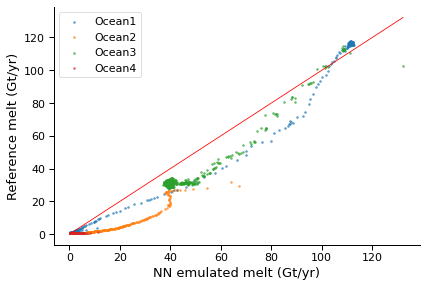

7.69097192431995


In [53]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)

Mod = [{'Ocean' : 'Ocean1', 'Var' : Var_X_non_position_driving, 'Epoch' : 8, 'Extra_n' : 'Drivingvsinterp'}]
for m in Mod:
    RMSEs, Melts, Modded_Melts = Plotting.Plot_Melt_to_Modded_melt(save = False, 
        Save_name = '', Ocean_target = OcT, NN_attributes = m, Display_label = False, Display_title = False)

PWD : /home/bouissob/Code
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384123_Ex_Drivingvsinterp/model_8.h5
239
Done computing for Ocean1 in : 18 s
239
Done computing for Ocean2 in : 17 s
1199
Done computing for Ocean3 in : 91 s
1199
Done computing for Ocean4 in : 91 s


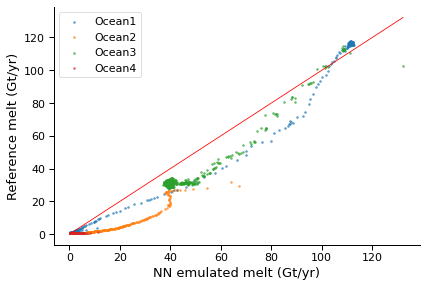

7.69097192431995


In [57]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)
Mod = [{'Ocean' : 'Ocean1', 'Var' : Var_X_non_position_driving, 'Epoch' : 8, 'Extra_n' : 'Drivingvsinterp'}]
for m in Mod:
     RMSEs3, Melts3, Modded_Melts3 = Plotting.Plot_Melt_to_Modded_melt(save = False, 
        Save_name = '', Ocean_target = OcT, NN_attributes = m, Display_label = False, Display_title = False, recursive_t = True)

In [28]:
print(Melts[0][0:5][0:3], Melts2[0:5][0:3])
print(Modded_Melts[0][0:5][0:3], Modded_melts2[0:5][0:3])


[3.745597456647187, 2.7133308536640057, 2.3177190037071305] [3.74559746 2.71333085 2.317719  ]
[11.111973625179381, 6.434877411061898, 4.8968980255723] [11.11197363  6.43487741  4.89689803]


In [34]:
Melts2

array([3.74559746, 2.71333085, 2.317719  , ..., 0.54365123, 0.55686716,
       0.54879381])

In [49]:
importlib.reload(Plotting_old)
importlib.reload(Computing_functions_old)
importlib.reload(Trainings)

PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

['/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384123_Ex_Drivingvsinterp']
Data variables used : thermalDriving halineDriving iceDraftngvsinterp                                                   
Data variables used : thermalDriving halineDriving iceDraft
Data variables used : thermalDriving halineDriving iceDraft
Data variables used : thermalDriving halineDriving iceDraft


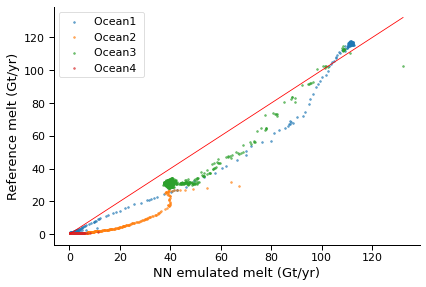

7.690971865008122


In [50]:

Mod = [{'Ocean' : 'Ocean1', 'Var' : Var_X_non_position_driving, 'Epoch' : 8, 'Extra_n' : 'Drivingvsinterp'}]
for m in Mod:
    RMSEs2, Params, Melts2, Modded_melts2, Neurs, Oc_mask = Plotting_old.Plot_Melt_to_Modded_melt(save = False, 
        Save_name = '', Ocean_target = OcT, NN_attributes = m, Display_label = False, Display_title = False)

In [18]:
Melts2

array([3.74559746, 2.71333085, 2.317719  , ..., 0.54365123, 0.55686716,
       0.54879381])

In [21]:
Computing_functions.Flatten_list_list(Melts)

array([3.74559746, 2.71333085, 2.317719  , ..., 0.55686716, 0.54879381,
       0.55239589])

In [67]:
print(Melts[0][0:5][0], Melts2[0:5][0])
print(Modded_Melts[0][0:5][0], Modded_melts2[0:5][0])


3.745597456647187 3.745597456647187
11.111973255757475 11.111973625179381


In [42]:
Computing_functions.Flatten_list_list(Melts).mean()

20.326628259782336

In [43]:
Melts2.mean()

20.303069729001727

In [ ]:
7.693965209536431 # Old method 
7.693965268907425 # New method while looping on every t


7.69097192431995 # New method one compute
7.690971923005611 # Float64 method thingy

7.690971865008122


In [18]:
Modded_melts2

array([11.11197363,  6.43487741,  4.89689803, ...,  0.33851504,
        0.36344711,  0.34471217])

In [10]:
Composite = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4', 'CPL_EXP10_rst','CPL_EXP13_rst', 'CPL_EXP22_rst', 'CPL_EXP23_rst']
Ocean_tar = ['CPL_EXP11_rst', 'CPL_EXP12_rst']
Composite_id = 1653216190
NN_attributes = {'Ocean' : Composite, 'Extra_n' : '', 'Uniq_id' : Composite_id}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Neur_seq', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_128_N_128_128_128_128_128_Ch_0-1653216190_Ex_, ( 1 / 1)
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_128_N_128_128_128_128_128_Ch_0-1653216190_Ex_/model_128.h5
Done computing for CPL_EXP11_rst in : 42 s
Done computing for CPL_EXP12_rst in : 42 s


In [2]:
p = '/bettik/bouissob/Method_Data/COM_NEMO-CNRS/Method_3/Ocean1.csv'
df = pd.read_csv(p)
T = [0, 2, 120, 239]
df2 = df.loc[df.date.isin(T)]
df2.head()

,y,x,meltRate,thermalDriving,halineDriving,iceDraft,bathymetry,date,Distances_ground_line,Distances,Distances_front_line,Slope_iceDraft,Slope_iceDraft_x,Slope_iceDraft_y,Slope_bathymetry,Slope_bathymetry_x,Slope_bathymetry_y,temperatureYZ,salinityYZ
0,1000.0,515000.0,1.445518e-09,0.009086,0.127754,82.815510,124.00000,0,2000.0,2000.0,2000.0,0.000000,0.0,0.000000,17.934357,17.934357,0.000000,-1.900030,33.893150
1,1000.0,637000.0,2.533100e-09,0.013837,0.194261,91.276440,579.32086,0,124000.0,124000.0,2000.0,7.109749,0.0,-7.109749,40.295700,-40.289978,-0.679138,-1.900030,33.893150
2,3000.0,515000.0,1.421181e-09,0.008926,0.125516,81.651650,124.00000,0,2000.0,2000.0,2000.0,0.000000,0.0,0.000000,18.584671,17.441551,6.417343,-1.900030,33.889171
3,3000.0,615000.0,2.025993e-09,0.012627,0.177358,89.908270,393.43146,0,102000.0,102000.0,2000.0,8.020058,0.0,-8.020058,28.304410,-28.295593,-0.706451,-1.900036,33.892456
4,3000.0,617000.0,1.932426e-09,0.012012,0.168752,90.281364,407.81378,0,104000.0,104000.0,2000.0,8.546814,0.0,-8.546814,26.577932,-26.568542,-0.706451,-1.900036,33.892456


/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656189840_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656173410_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656185286_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656173420_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656177874_Ex_First_prune


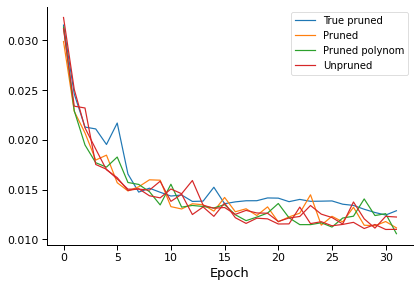

In [29]:
Mod = [{'Ocean' : OcT, 'Uniq_id' :  1656189840}, {'Ocean' : OcT, 'Uniq_id' :  1656173410}, 
       {'Ocean' : OcT, 'Uniq_id' : 1656185286} ,
       {'Ocean' : OcT, 'Uniq_id' : 1656173420}, {'Ocean' : OcT, 'Uniq_id':  1656177874},
      ]#{'Ocean' : OcT, 'Uniq_id' : 1653041657}]
Plotting.Plot_Loss_against_loss(Mods = Mod, Desired_comparaison=['val_mse'], save = False, Desired_length=64,
                                label = ['True pruned', 'Pruned', 'Pruned polynom' , 'Unpruned', 'Unpruned'])
#                label = ['No lr changes', 'Lr /5 every 8', 'Lr /2 every 10', 'lr plateau'])
#label = ['No lr changes', 'Lr /5 every 8', 'Lr /2 every 10', 'lr plateau']

In [7]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)

PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [10]:
NN_attributes = {'Ocean' : OcT, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_ISOMIP'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='target_sparsity', 
            Ocean_target = OcT, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656196107_Ex_Prune_benchmark_ISOMIP, ( 1 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656199271_Ex_Prune_benchmark_ISOMIP, ( 2 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656202354_Ex_Prune_benchmark_ISOMIP, ( 3 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656205406_Ex_Prune_benchmark_ISOMIP, ( 4 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656208454_Ex_Prune_benchmark_ISOMIP, ( 5 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656211494_Ex_Prune_benchmark_ISOMIP, ( 6 / 14)
Model : /home/bouissob/Code/

In [9]:
li

,target_sparsity,Overall_RMSE,Ocean1,Ocean2,Ocean3,Ocean4
0,0.108864,0.310873,0.556773,0.178794,0.402704,0.037126
1,0.211456,0.326101,0.584092,0.232912,0.417401,0.043750
2,0.309439,0.317902,0.549404,0.216699,0.413957,0.037770
3,0.399375,0.341471,0.629093,0.261854,0.428625,0.057106
4,0.483039,0.357784,0.643168,0.255102,0.458229,0.038728
5,0.561756,0.351496,0.632008,0.236125,0.450980,0.045794
6,0.632764,0.366792,0.627286,0.321292,0.470077,0.050707
7,0.697500,0.361963,0.611449,0.226899,0.477060,0.042236
8,0.755964,0.396918,0.681732,0.353765,0.508091,0.044352
9,0.808156,0.386278,0.670858,0.304077,0.497448,0.046349


In [15]:
li

([0.10886400000000007,
  0.21145599999999987,
  0.3094389999999998,
  0.39937500000000004,
  0.4830389999999999,
  0.5617559999999999,
  0.6327640000000001,
  0.6975,
  0.755964,
  0.808156,
  0.854839,
  0.894375,
  0.927639,
  0.955056],
 array([0.78315928, 0.55552703, 0.69856836, 0.09028847]),
 [0.31100575419414234,
  0.32606946433388523,
  0.3179573328676505,
  0.3413294890463412,
  0.35771416069448053,
  0.351657300049863,
  0.3668859100221776,
  0.3621135165067872,
  0.3971450228805684,
  0.3865177412624646,
  0.41599239967041346,
  0.4576605267172683,
  0.4781746475153181,
  0.5324090766694376])

In [ ]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_Composite'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='target_sparsity', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite, ( 1 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656257626_Ex_Prune_benchmark_Composite, ( 2 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656263189_Ex_Prune_benchmark_Composite, ( 3 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656315088_Ex_Prune_benchmark_Composite, ( 4 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP

In [31]:
li

([0.10886400000000007,
  0.21145599999999987,
  0.3094389999999998,
  0.10886400000000007,
  0.21145599999999987,
  0.3094389999999998],
 [array([9.04985956, 5.75312943]),
  array([14.49959684,  6.99669998]),
  array([14.02631611,  6.23662086]),
  array([13.88904444,  9.93929288]),
  array([8.78758289, 5.7674999 ]),
  array([10.78477635,  7.50120527])],
 [7.582824548090971,
  11.384026510041323,
  10.854330551556211,
  12.076735868421126,
  7.4325523278613534,
  9.2892271283883])

In [9]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_Composite'}
Trainings.Get_model_path_json(**NN_attributes, return_all = True)

['/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656257626_Ex_Prune_benchmark_Composite',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656263189_Ex_Prune_benchmark_Composite']

In [39]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)


PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [28]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : False, 'Extra_n' : 'Complexity_downgrade_composite'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Neur_seq', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_96_96_96_96_96_Ch_0-1656318593_Ex_Complexity_downgrade_composite, ( 1 / 3)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_32_32_96_96_Ch_0-1656323971_Ex_Complexity_downgrade_composite, ( 2 / 3)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_96_96_96_96_96_Ch_0-1656330067_Ex_Complexity_downgrade_composite, ( 3 / 3)


In [32]:
import time
p = '/home/bouissob/Code/Cached_data/Generic_benchmark/'
Interest = 'Neur_seq'
pd.DataFrame.to_csv(li, p + f'{Interest}_{int(time.time())}.csv', index = False)

In [37]:
Composite_id = 1653216190
NN_attributes = {'Ocean' : Composite, 'Extra_n' : '', 'Uniq_id' : Composite_id}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Neur_seq', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_128_N_128_128_128_128_128_Ch_0-1653216190_Ex_, ( 1 / 1)


In [27]:
li

,Neur_seq,Overall_RMSE,CPL_EXP11_rst,CPL_EXP12_rst
0,128_128_128_128_128,12.021785,14.757393,8.441917


0.10886400000000007
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

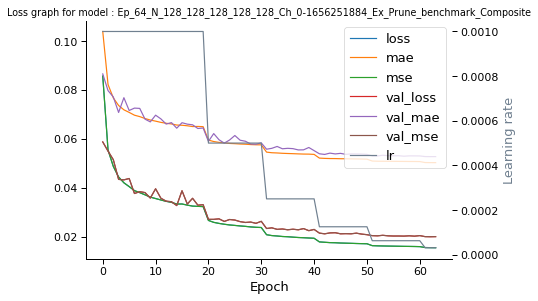

0.21145599999999987
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

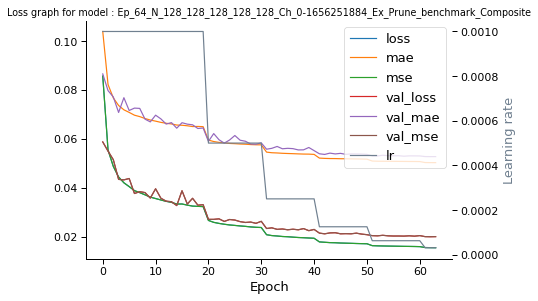

0.3094389999999998
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

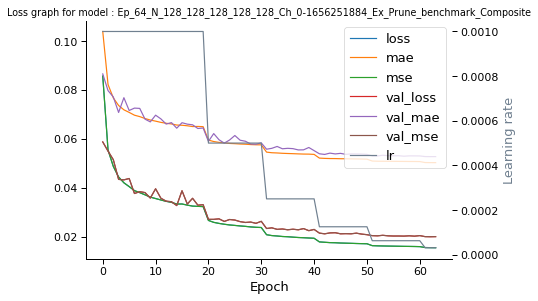

0.10886400000000007
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

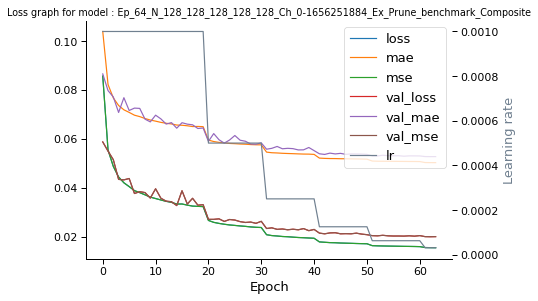

0.21145599999999987
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

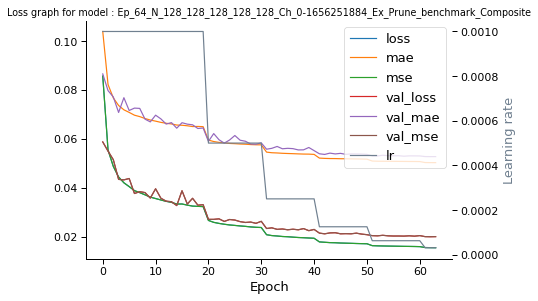

0.3094389999999998
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

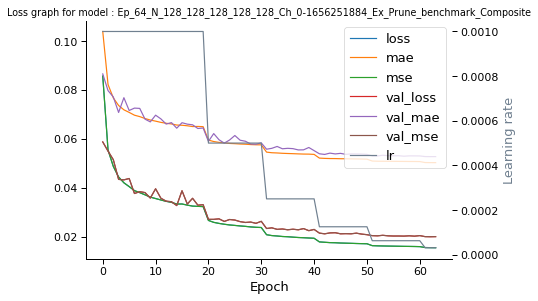

In [42]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_Composite'}
ps = Trainings.Get_model_path_json(**NN_attributes, return_all = True)
for p in ps:
    plt.figure()
    Config = Trainings.Get_model_attributes(p)
    att = {'Ocean' : OcT, 'Uniq_id' : Config['Uniq_id']}
    print(Config['target_sparsity'])
    Plotting.Plot_loss_model(Second_axis=['lr'], **NN_attributes)